In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import Levenshtein
import itertools
import RNA

nucleotides = {'A':0,'G':1,'U':2,'C':3}
nucleotides_text = ['A','G','U','C']

**Parameters**

In [3]:
initial_rna = "ACC"
target = "AGCC"
global_enviornmental_factors = []
generations = 5
base_mutation = np.array([[0.925, 0.025, 0.025, 0.025], [0.025, 0.925, 0.025, 0.025], [0.025, 0.025, 0.925, 0.025], [0.025, 0.025, 0.025, 0.925]])

**Update Parameters**

In [4]:
def calculate_environmental_factors (rna_population, enviornmental_factors):
    return enviornmental_factors

def calculate_mutation_rate (factors, mutation_rate = base_mutation):
    return mutation_rate

**Find Indel Probability**

In [5]:
def calculate_insertion_rate (sequence, factors, insertion_rate = 0.075):
    return insertion_rate

def calculate_deletion_rate (sequence, factors, deletion_rate = 0.075):
    return deletion_rate

**Transition Matrix Calculation**

In [6]:
def mutation_chance_list(mutation_list, mutation_rate):
    """Takes in matrix of mutations, outputs matrix of probabilities of each mutation"""
    probability_list = np.ones((len(mutation_list)))

    original = mutation_list[0]
    length_of_sequence = len(original)

    for i, column in enumerate(mutation_list):
        for k in range(length_of_sequence):
            original_index = nucleotides[original[k]]
            possibility_index = nucleotides[column[k]]
            probability_list[i] *= mutation_rate[original_index, possibility_index]

    probability_list[0] = np.maximum(0, 1 - np.sum(probability_list[1:]))

    return probability_list

def generate_combinations(original):
    n = len(original)
    
    all_combinations = [''.join(seq) for seq in itertools.product(nucleotides_text, repeat=n)]
    
    all_combinations.remove(original)
    
    all_combinations.insert(0, original)
    
    return all_combinations


**Fitness**

In [7]:
def fitness (target_distance, target_mfe, sequence):
    sequence_distance = Levenshtein.distance(sequence, target)
    if (sequence_distance > target_distance):
        return False
    sequence_mfe = RNA.fold(sequence)[1]
    if (sequence_mfe > target_mfe):
        return False

    return True
    

**Simulation**

In [17]:
def replicate_rna (initial_rna, mutation_rate, generations, target):

    rna_population = [initial_rna]
    full_population = [initial_rna]
    population_history = [[initial_rna]]
    
    target_mfe = abs(RNA.fold(target)[1]-RNA.fold(initial_rna)[1])
    target_distance = Levenshtein.distance(initial_rna, target)

    enviornmental_factors = calculate_environmental_factors(rna_population, global_enviornmental_factors)

    for _ in range(generations):

        enviornmental_factors = calculate_environmental_factors(rna_population, enviornmental_factors)
        mutation_rate = calculate_mutation_rate(enviornmental_factors, mutation_rate)
        
        new_population = []

        for rna in rna_population:
            old_rna = rna
            o_len = len(old_rna)
            new_rna = ""
            nucleotides_gain = 0
            
            insertion_rate = calculate_insertion_rate(rna, enviornmental_factors)
            deletion_rate = calculate_deletion_rate(rna, enviornmental_factors)

            while (insertion_rate > random.random()):
                nucleotides_gain += 1
            while (deletion_rate > random.random()):
                nucleotides_gain -= 1
            try:
                if (nucleotides_gain > 0):
                    for _ in range(nucleotides_gain):
                        index = random.randint(0, o_len)
                        old_rna = old_rna[:index] + random.choice(nucleotides_text) + old_rna[index:]
                        o_len += 1
                elif (nucleotides_gain < 0):
                    for _ in range(-nucleotides_gain):
                        index = random.randint(0, o_len)
                        old_rna = old_rna[:index] + old_rna[index+1:]
                        o_len -= 1
            except Exception:
                pass

            mutation_list = generate_combinations(old_rna)
            chance_list = mutation_chance_list(mutation_list, mutation_rate)
            
            new_rna = mutation_list[np.random.choice(len(chance_list), p=chance_list/chance_list.sum())]
            
            new_population.append(str(new_rna))

        full_population += new_population.copy()
        rna_population += [rna for rna in new_population if fitness(target_distance, target_mfe, rna)]
        population_history.append(rna_population)
        if target in rna_population:
            break
    
    return rna_population, full_population, population_history

**Data Analysis**

Initial RNA (length 1): A
Generations needed for length 1: 9
Initial RNA (length 1): A
Generations needed for length 1: 6
Initial RNA (length 1): C
Generations needed for length 1: 11
Initial RNA (length 1): C
Generations needed for length 1: 12
Initial RNA (length 1): C
Generations needed for length 1: 8
Initial RNA (length 1): C
Generations needed for length 1: 8
Initial RNA (length 1): A
Generations needed for length 1: 8
Initial RNA (length 1): C
Generations needed for length 1: 9
Initial RNA (length 1): U
Generations needed for length 1: 12
Initial RNA (length 1): C
Generations needed for length 1: 9
Initial RNA (length 2): GC
Generations needed for length 2: 12
Initial RNA (length 2): GU
Generations needed for length 2: 9
Initial RNA (length 2): CG
Generations needed for length 2: 8
Initial RNA (length 2): CC
Generations needed for length 2: 9
Initial RNA (length 2): CC
Generations needed for length 2: 8
Initial RNA (length 2): CC
Generations needed for length 2: 10
Initial RNA (

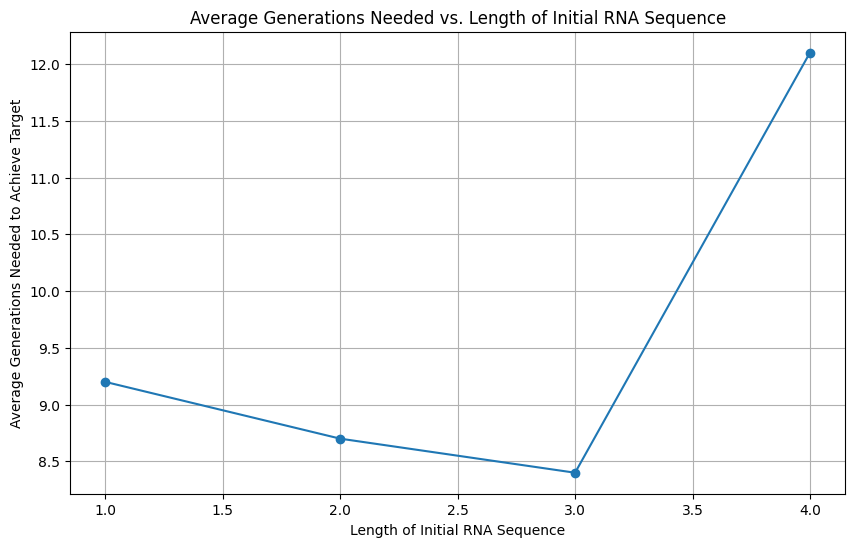

In [18]:
def plot_generations_to_target(target, min_length, max_length, mutation_rate, generations, trials):
    lengths = range(min_length, max_length + 1)
    average_generations_needed = []

    for length in lengths:
        generations_needed = []
        for _ in range(trials):
            initial_rna = ''.join(random.choices(nucleotides_text, k=length))
            print(f"Initial RNA (length {length}): {initial_rna}")
            _, _, population_history = replicate_rna(initial_rna, mutation_rate, generations, target)
            generations_needed.append(len(population_history))
            print(f"Generations needed for length {length}: {len(population_history)}")
        
        average_generations_needed.append(np.mean(generations_needed))

    plt.figure(figsize=(10, 6))
    plt.plot(lengths, average_generations_needed, marker='o')
    plt.xlabel('Length of Initial RNA Sequence')
    plt.ylabel('Average Generations Needed to Achieve Target')
    plt.title('Average Generations Needed vs. Length of Initial RNA Sequence')
    plt.grid(True)
    plt.show()

target = "AU"
mutation_rate = calculate_mutation_rate (global_enviornmental_factors, base_mutation)
generations = 1000
trials = 10

plot_generations_to_target(target, 1, 4, mutation_rate, generations, trials)